<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4529 entries, 2000-11-21 to 2018-11-21
Data columns (total 1 columns):
Close    4529 non-null float64
dtypes: float64(1)
memory usage: 70.8 KB
None
              Close
Date               
2000-11-21  24.2500
2000-11-22  25.1875
2000-11-24  28.9375
2000-11-27  28.0000
2000-11-28  25.0312
             Close
count  4529.000000
mean    290.353723
std     407.211585
min       5.970000
25%      39.849998
50%     117.889999
75%     327.440002
max    2039.510010


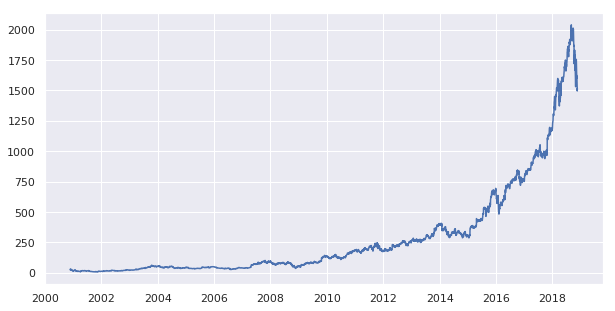

               Close
Date                
2018-11-08 -0.000330
2018-11-09 -0.024504
2018-11-12 -0.045140
2018-11-13 -0.003476
2018-11-14 -0.019913
2018-11-15  0.012696
2018-11-16 -0.016204
2018-11-19 -0.052251
2018-11-20 -0.011191
2018-11-21  0.014123


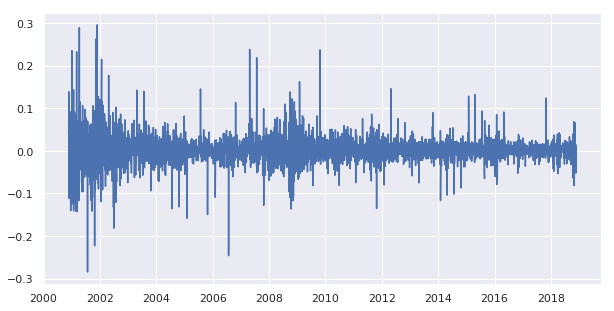

Using TensorFlow backend.


3170 1359
Epoch 1/100
3168/3168 [==============================] - 25s 8ms/step - loss: 0.0050 - acc: 3.1566e-04
Epoch 2/100
3168/3168 [==============================] - 25s 8ms/step - loss: 9.7120e-05 - acc: 3.1566e-04
Epoch 3/100
3168/3168 [==============================] - 25s 8ms/step - loss: 9.1701e-05 - acc: 3.1566e-04
Epoch 4/100
3168/3168 [==============================] - 25s 8ms/step - loss: 9.0367e-05 - acc: 3.1566e-04
Epoch 5/100
3168/3168 [==============================] - 25s 8ms/step - loss: 8.6994e-05 - acc: 3.1566e-04
Epoch 6/100
3168/3168 [==============================] - 25s 8ms/step - loss: 8.6278e-05 - acc: 3.1566e-04
Epoch 7/100
3168/3168 [==============================] - 23s 7ms/step - loss: 8.2828e-05 - acc: 3.1566e-04
Epoch 8/100
3168/3168 [==============================] - 24s 8ms/step - loss: 8.1470e-05 - acc: 3.1566e-04
Epoch 9/100
3168/3168 [==============================] - 24s 8ms/step - loss: 7.8211e-05 - acc: 3.1566e-04
Epoch 10/100
3168/3168 [=======

In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from random import seed

seed(0)

Data = pd.read_csv('AMZN.csv',header=0, usecols=['Date', 'Close'],parse_dates=True,index_col='Date')
print(Data.info())
print(Data.head())
print(Data.describe())

plt.figure(figsize=(10,5))
plt.plot(Data)
plt.show()

DataPCh = Data.pct_change()

LogReturns = np.log(1 + DataPCh) 
print(LogReturns.tail(10))

plt.figure(figsize=(10,5))
plt.plot(LogReturns)
plt.show()


from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

def DatasetCreation(dataset, TimeStep=1):
	DataX, DataY = [], []
	for i in range(len(dataset)-TimeStep-1):
		a = dataset[i:(i+TimeStep), 0]
		DataX.append(a)
		DataY.append(dataset[i + TimeStep, 0])
	return np.array(DataX), np.array(DataY)


scaler = MinMaxScaler()
DataScaled = scaler.fit_transform(Data)

np.random.seed(7)

TrainLen = int(len(DataScaled) * 0.70)
TestLen = len(DataScaled) - TrainLen
TrainData = DataScaled[0:TrainLen,:] 
TestData  = DataScaled[TrainLen:len(DataScaled),:]

print(len(TrainData), len(TestData))

TimeStep = 1
TrainX, TrainY = DatasetCreation(TrainData, TimeStep)
TestX, TestY = DatasetCreation(TestData, TimeStep)

TrainX = np.reshape(TrainX, (TrainX.shape[0], 1, TrainX.shape[1]))
TestX = np.reshape(TestX, (TestX.shape[0], 1, TestX.shape[1]))


model = Sequential()
model.add(LSTM(256, input_shape=(1, TimeStep)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
model.fit(TrainX, TrainY, epochs=100, batch_size=1, verbose=1)
model.summary()

score = model.evaluate(TrainX, TrainY, verbose=0)
print('Keras Model Loss = ',score[0])
print('Keras Model Accuracy = ',score[1])

TrainPred = model.predict(TrainX)
TestPred = model.predict(TestX)

TrainPred = scaler.inverse_transform(TrainPred)
TrainY = scaler.inverse_transform([TrainY])

TestPred = scaler.inverse_transform(TestPred)
TestY = scaler.inverse_transform([TestY])

TrainPredictPlot = np.empty_like(DataScaled)
TrainPredictPlot[:, :] = np.nan
TrainPredictPlot[1:len(TrainPred)+1, :] = TrainPred

TestPredictPlot = np.empty_like(DataScaled)
TestPredictPlot[:, :] = np.nan
TestPredictPlot[len(TrainPred)+(1*2)+1:len(DataScaled)-1, :] = TestPred

plt.plot(scaler.inverse_transform(DataScaled))
plt.plot(TrainPredictPlot)
plt.plot(TestPredictPlot)
plt.show()
